## Извлечение отношений

Традиционно извлечение отношений решается как задача классификации. Нужно связать именованные сущности в предложении какими-то заранее известными типами связей. Чаще всего это отношения вроде work_at, born_in, located_in, head_of. В биомедициских текстах извлечение отношений применяется для извлечения взаимодействия белков и поиска пар (лекарство, болезнь). Количество аргументов вообще может быть любым, но чаще всего ограничиваются бинарными отношениями (субъект, предикат, объект). 

Посмотрим как это работает на размеченном датасете.

Данные - https://github.com/thunlp/FewRel/blob/master/data/train.json


FewRel - это датасет для few-shot обучения. Это немного другая задача, для которой нужна нейронная сеть с определенной архитектурой и тест сет тут состоит из отношений других типов. Подробнее про задачу и датасет можно почитать вот тут - https://arxiv.org/pdf/1810.10147v1.pdf.

Мы его будем использовать для обычной классификации. Оценивать качество будем на кросс-валидации.


In [1]:
import json
import os
from collections import Counter
from itertools import combinations
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import spacy
nlp = spacy.load('en')

Посмотрим на данные.

In [2]:
data = json.load(open('train.json'))

В датасете 64 типа отношений и у каждого типа 700 - предложений, в которых оно встречается.

In [32]:
len(data.keys())

64

Типы отношений обознчаются как-то условно, но в статье про датасет можно посмотреть соответствие.

In [33]:
data.keys()

dict_keys(['P931', 'P4552', 'P140', 'P1923', 'P150', 'P6', 'P27', 'P449', 'P1435', 'P175', 'P1344', 'P39', 'P527', 'P740', 'P706', 'P84', 'P495', 'P123', 'P57', 'P22', 'P178', 'P241', 'P403', 'P1411', 'P135', 'P991', 'P156', 'P176', 'P31', 'P1877', 'P102', 'P1408', 'P159', 'P3373', 'P1303', 'P17', 'P106', 'P551', 'P937', 'P355', 'P710', 'P137', 'P674', 'P466', 'P136', 'P306', 'P127', 'P400', 'P974', 'P1346', 'P460', 'P86', 'P118', 'P264', 'P750', 'P58', 'P3450', 'P105', 'P276', 'P101', 'P407', 'P1001', 'P800', 'P131'])

In [34]:
c = Counter([len(data[k]) for k in data])

In [35]:
c

Counter({700: 64})

Каждый инстанс - это предложения и разметка. Ключ h - это главное слово, t - зависимое. Предложения разделены на токены и в разметке указаны слова, уникальный номер и индексы сущности в предложении.

In [9]:
data['P127'][0]

{'tokens': ['Amityville',
  'is',
  'the',
  'westernmost',
  'station',
  'on',
  'the',
  'Babylon',
  'Branch',
  'of',
  'the',
  'Long',
  'Island',
  'Rail',
  'Road',
  'in',
  'Suffolk',
  'County',
  ',',
  'New',
  'York',
  '.'],
 'h': ['babylon branch', 'Q4838506', [[7, 8]]],
 't': ['long island rail road', 'Q125943', [[11, 12, 13, 14]]]}

Для обучения нам нужно каким-то образом перевести такую разметку в один вектор и сопоставить ему тип отношения.

Как это сделать? 

Стандартный способ - достать контекст слева от первой сущности, между сущностями и после второй сущности. Левые и правые контексты можно ограничить каким-то числом (например, 3 слова). Для каждого контекста можно получить вектор обычными способами - например через TfidfVectorizer. Потом эти вектора конкатенируются в один.

Ещё в этот вектор можно добавить длину контекста, тэги сущностей, сами сущности, порядок сущностей и т.д.

In [3]:
# тут будем держать сущности
ent1 = []
ent2 = []

# тут будем хранить контексты
left = []
right = []
middle = []

# целые предложения тоже на всякий случай достанем
sents = []

# целевая переменная (тип отношений будет тут)
target = []


# проходим по типам отношений
for key in data:
    # по каждому инстансу
    for instance in data[key]:
        
        tokens = instance['tokens']
        sents.append(tokens)
        
        ent1.append(' '.join([tokens[i] for i in instance['h'][2][0]]))
        ent2.append(' '.join([tokens[i] for i in instance['t'][2][0]]))
        
        
        # h и t не обязательно идут в таком порядке
        # чтобы достать контексты нужно понять что из них идет первым
        if instance['h'][2][0][0] < instance['t'][2][0][0]:
            first, second = 'h', 't'
        else:
            second, first = 'h', 't'
        
        
        # индексы сущностей
        first_start = instance[first][2][0][0]
        first_end = instance[first][2][0][-1]
        second_start = instance[second][2][0][0]
        second_end = instance[second][2][0][-1]

        # левый контекст - это три слова слева от начала первой сущности
        # если слева меньше 3 слов, то добавим тэгов <START>
        left_context = tokens[max(0, first_start-3):first_start]
        left.append((['<START>']*(3-len(left_context))) + left_context)
        
        # правый контекст - это 3 слова после последнего слова второй сущности
        # если справа меньше 3 слов, то добавим тэгов <END>
        right_context = tokens[second_end+1:second_end+4]
        right.append(right_context + (['<END>']*(3-len(right_context))))

        # средний контекст - это слова между последний словом первой сущности 
        # и первым словом второй сущности
        middle_context = tokens[first_end+1:second_start]
        middle.append(middle_context)

        target.append(key)
        
        

In [4]:
#это те же самые векторы fasttext только в другом формате, чтобы не загружать в память (у меня ее немного)
F = np.memmap("fasttext_eng\\embed.dat", dtype='float32', mode="r", shape=(2519370, 300))
with open("fasttext_eng\\embed.vocab", encoding='utf-8') as f:
    vocab_list = map(str.strip, f.readlines())
vocab_dict = {w: k for k, w in enumerate(vocab_list)}

In [5]:
def getWordVecs_1(text,dim):
    text = text.split()
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    for i,word in enumerate(words):
        try:
            v = F[vocab_dict[word]]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
         vector = np.zeros((dim))     
    return vector

In [6]:
def vectorize(texts, dim):
    vects = np.zeros((len(texts), dim))
    for i, text in enumerate(texts):
        vects[i] = getWordVecs_1(text,dim)        
    return  vects   

In [7]:
lefts_s = [' '.join(l) for l in left]
rights_s = [' '.join(l) for l in right]
middles_s = [' '.join(l) for l in middle]

# tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))

# tfidf.fit(lefts_s + rights_s + middles_s)

# l = tfidf.fit_transform(lefts_s)
# r = tfidf.fit_transform(rights_s)
# m = tfidf.fit_transform(middles_s)

l = vectorize(lefts_s,300)
r = vectorize(rights_s,300)
m = vectorize(middles_s,300)
#X = hstack((l,m,r))
# X = csr_matrix(hstack([l,m,r])) # чтобы можно было по индексам доставать

In [8]:
x = csr_matrix(np.hstack((l,m,r)))

In [9]:
x

<44800x900 sparse matrix of type '<class 'numpy.float64'>'
	with 36337770 stored elements in Compressed Sparse Row format>

In [10]:
len(x.data)# это очень много, мой комп не потянет столько считать

36337770

In [14]:
svd = TruncatedSVD(600)
svd_X = svd.fit(x)

In [17]:
svd_X = svd.transform(x)

In [22]:
len(svd_X.data) #матрица, конечно, стала квадратной после разложения, ну что поделать

44800

In [11]:
y = np.array(target)

Оценим качество на StratifiedKFold. Посчитаем стандартные метрики (c микро и макро усреднением). Ещё сделаем матрицу ошибок.

In [23]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(svd_X, y):
    # Можно конечно что-нибудь посложнее, но для примера хватит и логрега
    clf = LogisticRegression()
    clf.fit(svd_X[train_index], y[train_index])
    preds = clf.predict(svd_X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)
    

In [24]:
print(metrics_micro/N) #результат не поражает воображения, но слава богу, хоть досчиталось
print(metrics_macro/N)

[0.37962054 0.37962054 0.37962054]
[0.38422835 0.37962054 0.36853798]


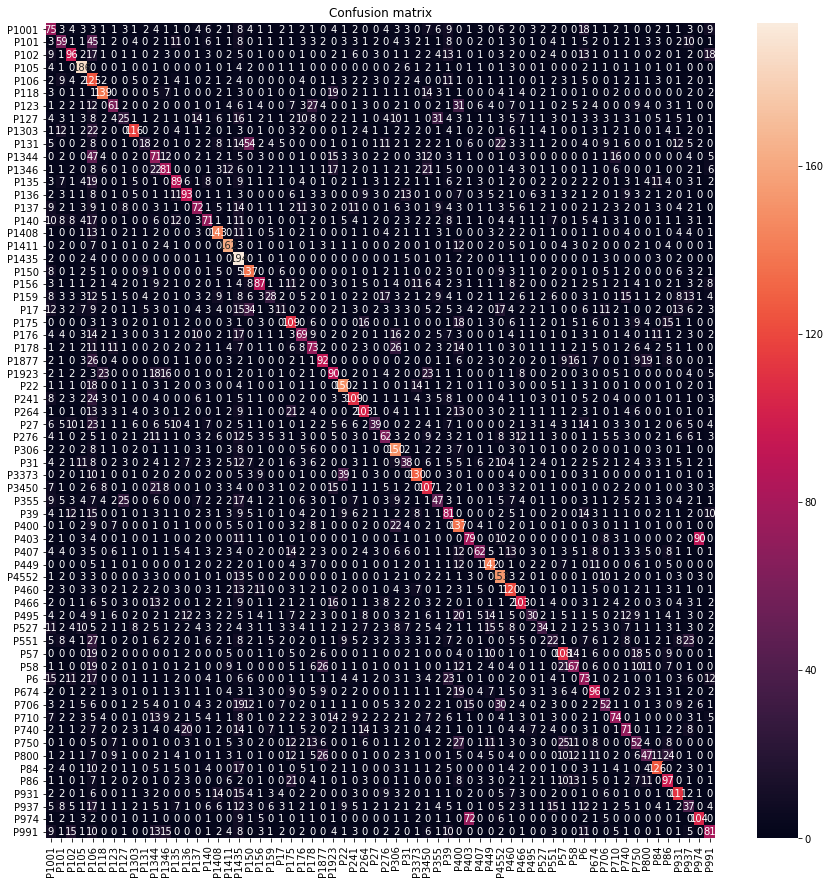

In [25]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=np.round(conf/3).astype(int), 
            annot=True, 
            fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax)
plt.title("Confusion matrix")
plt.show()

Качество получается не очень хорошее.
Путаются классы, например, P106 и P1344/ P403 и P974. В статье написано, что P106 - это область деятельности человека(работа),а P1344 - событие, в котором участвовал человек или организация. P403 - это водоем,куда впадает река, а P974 - поток или река, которая впадает в основновное русло. Судя по этим примерам, смешение настуает в случае семантически близких классов.

## Другие подходы

Для нейросетей задачу можно представить как seq2seq - каждому токену соответствует тэг H, T или O (можно добавить Begin, Inside тэги, чтобы отметить многословные сущности). И можно вообще решать задачу извлечения сущностей и отношений вместе. Про это читать,
например, тут:  https://www.semanticscholar.org/paper/Joint-learning-of-named-entity-recognition-and-Xu-Li/31ce449618068343f9f83c904c7fd062ba943c8e?navId=references

Извлечение отношений часто пытаются решать без учителя. 

Один из подходов - **bootstrapping**, о котором мы говорили в прошлый раз. Можно выбрать какой-то набор пар сущностей, которые выражают отношение и найти предложения, в которых эта пара сущностей встречается. Потом найти похожие по контекстам предложения и считать их представителями этого класса. Затем можно достать пары сущностей, в которых они употреблены и повторить все заново. 

Про это можно почитать вот тут:

1) одна из первых работ - https://pdfs.semanticscholar.org/6f16/7cce628ec4983788ddf21587630afebf43ce.pdf?_ga=2.136426931.2051797770.1542970757-1216332217.1520769589 (от создателя гугла)

2) https://pdfs.semanticscholar.org/189e/d3f749766d02d42eb5b6d71017e085c212d4.pdf?_ga=2.112375175.2051797770.1542970757-1216332217.1520769589

3) Тут бустраппинг делается с помощью word2vec -https://pdfs.semanticscholar.org/fe6e/56ec0a1f5d673a4ab22e716f2c846b497f9c.pdf?_ga=2.179043751.2051797770.1542970757-1216332217.1520769589



Другой популярный метод - **distant supervision**. Идея очень похожая, только вместо того, чтобы самим придумывать положительные примеры - их берут из какой-нибудь базы данных. Например, из DBPedia или из Freebase. Достав большое количество упоминаний, можно собрать уже достаточно большую обучающую выборку.

Почитать можно тут:  
1) первая статья по теме (от журафского) https://www.semanticscholar.org/paper/Distant-supervision-for-relation-extraction-without-Mintz-Bills/8f8139b63a2fc0b3ae8413acaef47acd35a356e0  
    
2) тут предлагаются методы убрать шум из такой разметки - https://www.semanticscholar.org/paper/Denoising-Distant-Supervision-for-Relation-via-Han-Liu/3d13ee24493a6c2a0477b15e5145ba5868c3df40 
    
   

Ещё одно большое направление - Open Information Extraction. Идея тут в том, чтобы извлекать из предложений (или текстов) все отношения в виде троек (субъект, предикат, объект). 

Например, из предложения __The U.S. president Barack Obama gave his speech on Tuesday and Wednesday to thousands of people.__ излекутся тройки:  

__(Barack Obama, president, U.S)  
(Barack Obama, gave, his speech)  
(Barack Obama, gave his speech, on Tuesday)  
(Barack Obama, gave his speech, on Wednesday)  
(Barack Obama, gave his speech, to thousands of people)__

Таким образом можно извлекать неограниченное количество типов отношений, т.е. не нужно для каждого типа размечать предложения. Однако появляется необходимость каким-то образом кластеризовать разные способы выражения одного типа отношений. 

Почитать про OpenIE можно тут:

1) оригинальная работа http://www.aaai.org/Papers/IJCAI/2007/IJCAI07-429.pdf  
2) одна из самых известных работ http://ml.cs.washington.edu/www/media/papers/reverb_emnlp2011.pdf  
3) одна из последних статей http://www.cse.iitd.ac.in/~mausam/papers/coling18.pdf  

Реализация OpenIE есть StandfordNLP и вот тут - https://github.com/dair-iitd/OpenIE-standalone